# UBS Challenge
## Lisam al Gaib

<img src="../pics/dune_img1.jpg"/>

In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import missingno as msno
import os
import sklearn

from importlib import reload

#import process_gini as pg
#import plots
#import model as m

In [23]:
path = "../data/skylab_instagram_datathon_dataset.csv"
df = pd.read_csv(path.replace("/", os.sep), sep=";")

string_vars = ["compset_group", "compset", "business_entity_doing_business_as_name",
"legal_entity_name", "domicile_country_name", "ultimate_parent_legal_entity_name",
"primary_exchange_name"]

for varname in df.columns:
    # 1. remove leading and trailing whitespaces and convert to lowercase
    df[varname] = df[varname].apply(lambda x: x.strip().lower() if isinstance(x, str) else x)
    # 2. replace all double whitespaces with single whitespaces
    df[varname] = df[varname].apply(lambda x: x.replace("  ", " ") if isinstance(x, str) else x)

# Was paying for this dataset worth it?

1. [About the data](#About-the-data)
2. [Data Analysis](#Data-Analysis)
   1. [Subsection A](#Subsection-A)
   2. [Subsection B](#Subsection-B)
3. [Conclusion](#Conclusion)

## About the data

Before getting into the results. Let's have a look at the given dataset

In [24]:
shape = df.shape
print(f"Not to bore you, here are only a few facts:\n")
print(f"The dataset has {shape[0]} rows and {shape[1]} columns.")
print(f"It consists of the date after the data was collected over a week.")
print("By data we mean information about the Instagram account such as number of follower, number of comments, number of likes and so on.")
print("For the interested reader check out the column names:")

df.describe(include = "all").fillna(0)

Not to bore you, here are only a few facts:

The dataset has 704313 rows and 15 columns.
It consists of the date after the data was collected over a week.
By data we mean information about the Instagram account such as number of follower, number of comments, number of likes and so on.
For the interested reader check out the column names:


,period,period_end_date,compset_group,compset,business_entity_doing_business_as_name,legal_entity_name,domicile_country_name,ultimate_parent_legal_entity_name,primary_exchange_name,calculation_type,followers,pictures,videos,comments,likes
count,704313,704313,704313,704313,704313,676558,458589,676558,458589,704313,5.792580e+05,695803.000000,684349.000000,6.953430e+05,6.959770e+05
unique,1,455,20,54,706,423,26,401,30,1,0.000000e+00,0.000000,0.000000,0.000000e+00,0.000000e+00
top,weekly,2023-07-08,luxury & premium & mainstream,us softlines analyst interest list,all brands,lvmh moet hennessy louis vuitton se,united states of america,lvmh moet hennessy louis vuitton se,new york stock exchange,metric value,0.000000e+00,0.000000,0.000000,0.000000e+00,0.000000e+00
freq,704313,1635,216241,113744,27755,27576,193509,27576,132071,704313,0.000000e+00,0.000000,0.000000,0.000000e+00,0.000000e+00
mean,0,0,0,0,0,0,0,0,0,0,1.342432e+07,344.272540,61.244426,3.043246e+04,2.163189e+06
std,0,0,0,0,0,0,0,0,0,0,1.106975e+08,2777.396873,564.468480,2.766459e+05,1.803193e+07
min,0,0,0,0,0,0,0,0,0,0,0.000000e+00,0.000000,0.000000,0.000000e+00,0.000000e+00
25%,0,0,0,0,0,0,0,0,0,0,3.013372e+05,19.000000,2.000000,3.710000e+02,1.727700e+04
50%,0,0,0,0,0,0,0,0,0,0,1.104144e+06,44.000000,7.000000,1.435000e+03,9.318400e+04
75%,0,0,0,0,0,0,0,0,0,0,4.479325e+06,122.000000,20.000000,5.872000e+03,4.577470e+05


## Data processing
Before generating any model, the data needs to be prepared to be able to run in a model.

<div class="alert alert-block alert-warning">
For details about the code please checkout code/data_creation.ipynb.
</div>

### Data cleaning

#### Static columns

There are 2 columns in this dataset that consist of only one value.
Also the weekday is only one value.

<div class="alert alert-block alert-success">
We can conclude that all data was gathered on Friday's.
</div>

- period: "Weekly"
- calculation_type: "Metric Value"
- Weekday: 5

#### Duplicates

The **major key observation** is that there are entries in the dataset that only differ by the column "compset". 

<div class="alert alert-block alert-danger">
<b>Assumption 1:</b> Certain posts of the account might be advertising in extremely different competition areas.
</div>

Therefore, those rows are merged and for the "compset" the union is taken .

By doing so, the number of rows got reduced by 400'000 rows: from 700'000 to 300'000.

In [25]:
grouping_columns = [col for col in df.columns if col != 'compset']

df.fillna('Group_Null', inplace=True)
result = df.groupby(grouping_columns).agg({'compset': lambda x: set(x)}).reset_index()
df = result
df = df.replace('Group_Null', np.nan)

There is an entry "All Brands" in the column "business_entity_doing_business_as_name" which has extremely high values.

<div class="alert alert-block alert-danger">
<b>Assumption 2:</b> "All Brands" represent the aggregation of all brands in the corresponding compset.</b>
</div>

In [26]:
df = df[df["business_entity_doing_business_as_name"] != "all brands"]

There is an entry "DO NOT USE" in "ultimate_parent_legal_entity_name". It appears 0.17 % in the dataset.

<div class="alert alert-block alert-danger">
<b>Assumptio 3:</b> We assume "DO NOT USE" only corresponds to not using this specific entry. The row itself can be kept.</b>
</div>
We simply repace this entry with NaN.

In [27]:
df.loc[df["ultimate_parent_legal_entity_name"] == 'do not use', "ultimate_parent_legal_entity_name"] = np.nan

#### Outlier

We have removed every entry consisting of the brand (business_entity_doing_business_as_name) "All Brands". We **assume** it is a summary of all the brands, hence the name. This assumption was **confirmed** by checking out the data.

#### Missing values

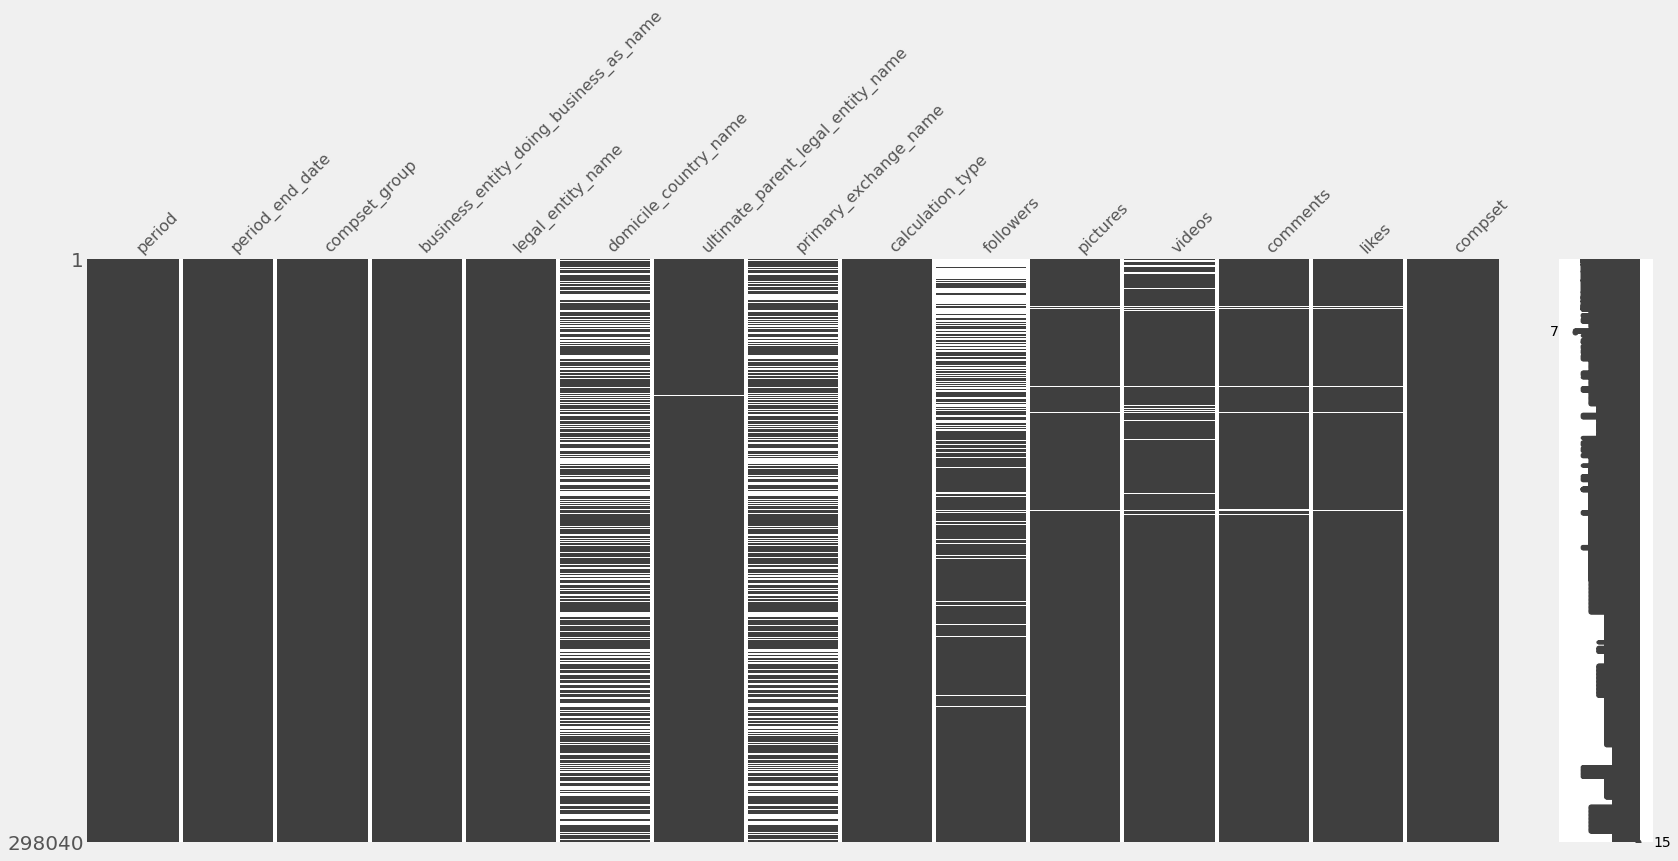

In [28]:
msno.matrix(df)
plt.show()

The above figure demonstrates that the columns "democile_country_name", "primary_exchange_name" and "followers" miss a lot of values. Furthermore

1. "democile_country_name" and "primary_exchange_name" are missing simultaneously
2. "democile_country_name" are not available for 33% of the companies

The following counter measurements were taken:

1. Download the dataset to infer the domicile for 239 companies from [domiclie_company_data](https://www.peopledatalabs.com/company-dataset). 172 values were discovered
1. Remove the columns "democile_country_name" and "primary_exchange_name" for the remaining 67 companies
2. Impute the missing values of followers by grouping by the date and brand and taking the mean of the two neighbouring values.
    - Do the same for all the other columns that consist of missing values
3. If there is time, find a dataset consisting of the country and brand name.

<div class="alert alert-block alert-danger">
<b>Assumption 4:</b> the "followers" is MAR (missing at random). If they are MNAR the data inputation is incorrect and should not be used
</div>

# Feature engineering

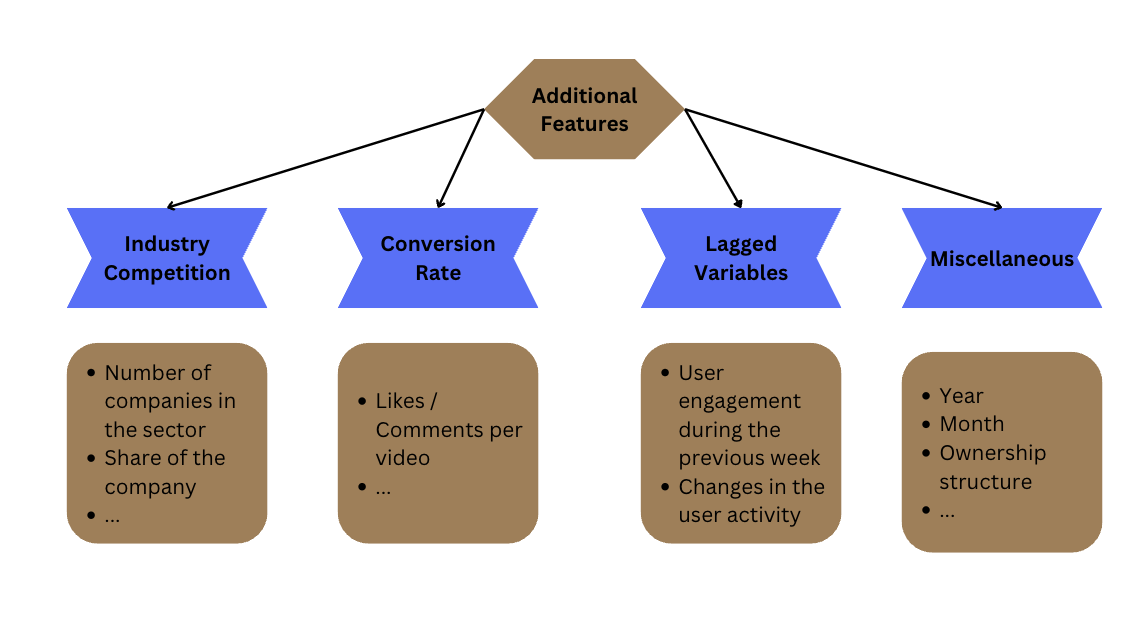

### Miscellaneous features

- Year, Month, Day

#### Ownership structure of businesses

The following features display the relationship of the two "A vs. B" entities. Mainly it is whether the legal_entity is owned by either the legal_entity or the business_entity.


- "ultimate_parent_vs_legal_entity"
- "ultimate_parent_vs_business_entity"
- "legal_entity_vs_business_entity"

### Lagged variables

Our PACF graphs (see **asy_eda.ipynb**) suggest that the user and company activity one week before have a significant predictive power. Therefore we have created variables that capture this information

<div class="alert alert-block alert-danger">
<b>Assumption 5: </b> the first available observation for the company coincides with the first week the company has opened its instagram account
</div>


/var/folders/xx/6tz780r13t57q640kxzkc46w0000gn/T/ipykernel_65884/4038751477.py:25: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  f.show()


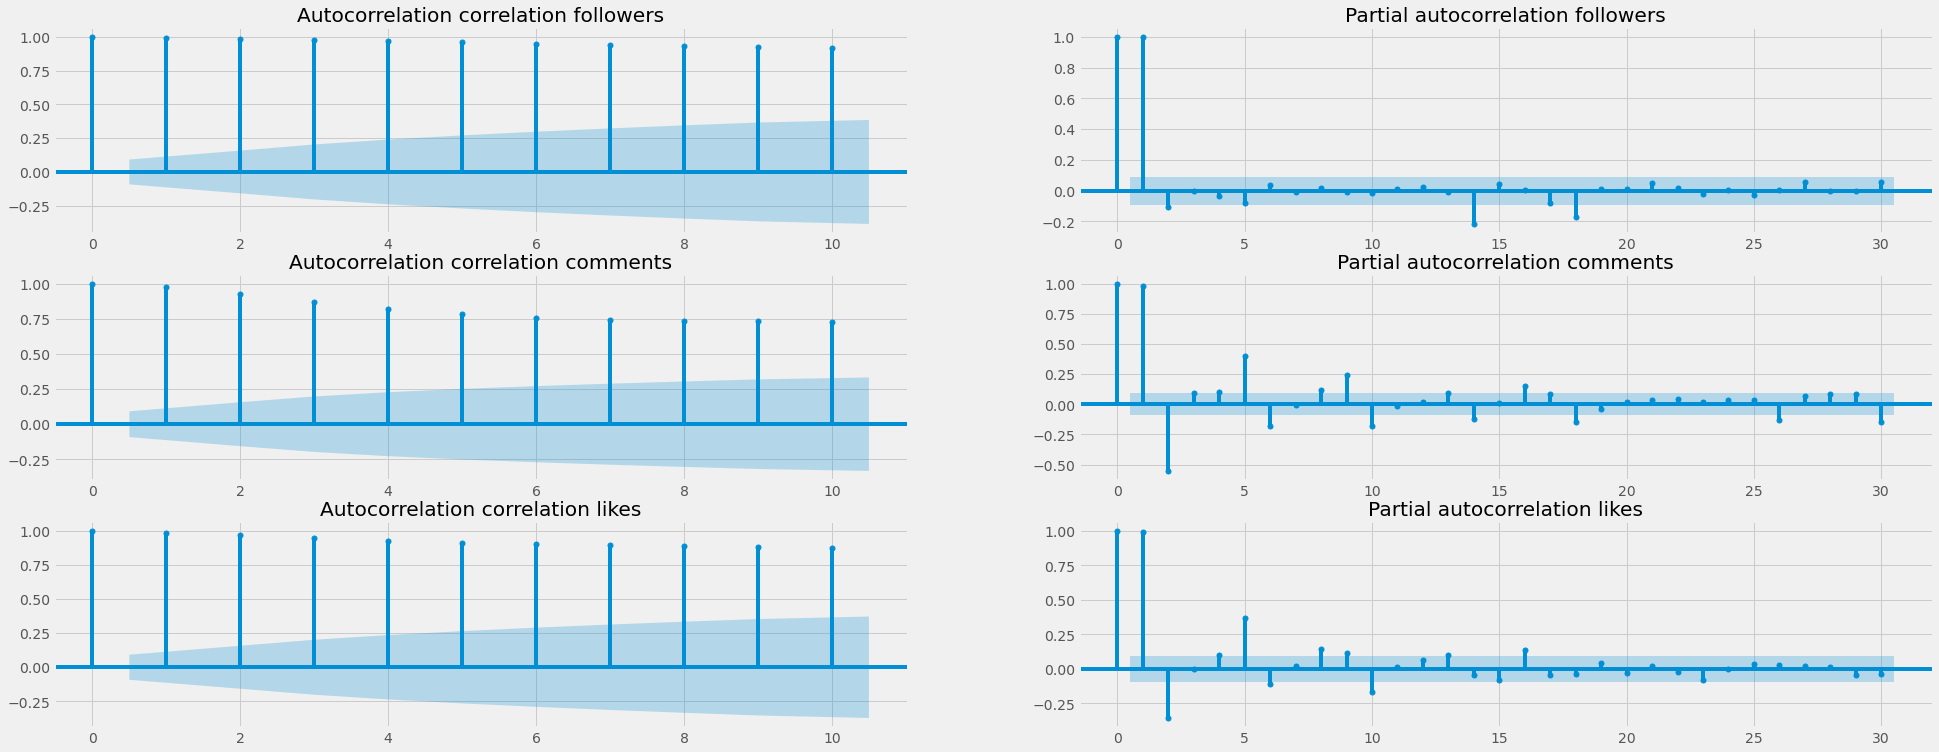

In [29]:
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf

plt.style.use('ggplot')
plt.style.use('fivethirtyeight')

df_agg_time = df.drop_duplicates(['business_entity_doing_business_as_name', 'period_end_date', 'followers', 'comments', 'likes']).groupby(['period_end_date']).mean()

lag_acf = 10
lag_pacf = 30

width, height = 30, 6

f, ax = plt.subplots(nrows=3, ncols=2, figsize=(width, 2*height))
vars_to_autocorrelate = ['followers', 'comments', 'likes']

for idx, varname in enumerate(vars_to_autocorrelate):
    #print(idx)
    plot_acf(df_agg_time[varname],lags=lag_acf, ax=ax[idx][0], missing='drop')
    plot_pacf(df_agg_time[varname],lags=lag_pacf, ax=ax[idx][1], method='ols')
    ax[idx, 0].set_title(f"Autocorrelation correlation {varname}")
    ax[idx, 1].set_title(f"Partial autocorrelation {varname}")
    
                         
f.show()

## Conversion rate

We have decided to create the variables that would reflect the effectiveness of the social media marketing campaign of the companies in the dataset. 

<div class="alert alert-block alert-danger">
<b>Assumption:</b> likes and comments are only for the videos and pictures uploaded within the same week</b>
</div>

In [30]:
# total involevement
df["total_involvement"] = df["comments"] + df["likes"]
df["total_company_activity"] = df["pictures"] + df["videos"]

df["conversion_rate_total"] = df["total_involvement"] / df["followers"]
df["return_on_activity"] = df["total_company_activity"] / df["total_involvement"] 

# COntent type
df["ratio_of_videos"] = df["videos"] / (df["pictures"] + df["videos"])
df["ratio_of_pictures"] = df["pictures"] / (df["pictures"] + df["videos"])

# ASSUMTION: we only like videos / photos from this week
df["likes_per_picture"] = df["likes"] / df["pictures"]
df["likes_per_video"] =   df["likes"] / df["videos"]
df["comments_per_picture"] =  df["comments"] / df["pictures"] 
df["comments_per_video"] =   df["comments"] / df["videos"]

# take care of zeros
df.loc[df["pictures"] + df["videos"] == 0, "ratio_of_videos"] = np.nan
df.loc[df["pictures"] + df["videos"] == 0, "ratio_of_pictures"] = np.nan

df.loc[df["pictures"] == 0, "likes_per_picture"] = np.nan
df.loc[df["videos"] == 0, "likes_per_video"] = np.nan
df.loc[df["pictures"] == 0, "comments_per_picture"] = np.nan
df.loc[df["videos"] == 0, "comments_per_video"] = np.nan

## Industry competition

The market dynamics will vary significantly depending on whether we are dealing with a monopoly, olygopoly or a near-perfect competition. In the former context, the advertizing is an important factor that drives the sales, whereas in the later case SMM does not play any significant role. 

To accout for that we have created a set of variables to characterise the competition, by industry, by industry and region. Furthermore the market power of an individual company is proxied by the ration of likes / comments compared to the overall sector performance

<div class="alert alert-block alert-danger">
<b>Assumption 6:</b> all the relevant competitors are inside the dataset </b>
</div>

In [31]:
vars_to_aggreg = ["followers", "videos", "pictures", "likes", "comments"]

vars_agg_ind = ["period_end_date", "compset_group", "business_entity_doing_business_as_name"]
vars_agg_ind_small = ["period_end_date", "compset_group"]

vars_agg_ind_country = ["period_end_date", "compset_group", "domicile_country_name", "business_entity_doing_business_as_name"]
vars_agg_ind_country_small = ["period_end_date", "compset_group", "domicile_country_name"]

df_group_ind = df.drop_duplicates(vars_agg_ind).groupby(vars_agg_ind_small)
df_group_ind_country = df.drop_duplicates(vars_agg_ind_country).groupby(vars_agg_ind_country_small)

df_cnt_industry = pd.DataFrame(df_group_ind.count()["business_entity_doing_business_as_name"])
df_cnt_industry_country = pd.DataFrame(df_group_ind_country.count()["business_entity_doing_business_as_name"])
df_sum_industry = df_group_ind.sum()[vars_to_aggreg]
df_sum_industry_country = df_group_ind_country.sum()[vars_to_aggreg]

# rename variables before the join
df_cnt_industry.rename(lambda x: x + "_cnt_industry", axis='columns', inplace=True)
df_cnt_industry_country.rename(lambda x: x + "_cnt_industry_country", axis='columns', inplace=True)
df_sum_industry.rename(lambda x: x + "_sum_industry", axis='columns', inplace=True)
df_sum_industry_country.rename(lambda x: x + "_sum_industry_country", axis='columns', inplace=True)

# the join
df = df.join(df_cnt_industry, on=vars_agg_ind_small)
df = df.join(df_cnt_industry_country, on=vars_agg_ind_country_small)
df = df.join(df_sum_industry, on=vars_agg_ind_small)
df = df.join(df_sum_industry_country, on=vars_agg_ind_country_small)

# creating ratios
vars_to_create = ["followers", "videos", "pictures", "likes", "comments"]

for varname in vars_to_create:
    # define varnames
    # input
    aggreg_ind = varname + "_sum_industry"
    aggreg_ind_country = varname + "_sum_industry_country"
    # output
    out_agg_ind = "fraction_" + aggreg_ind
    out_agg_ind_country = "fraction_" + aggreg_ind_country
    # compute fraction
    df[out_agg_ind] = df[varname] / df[aggreg_ind]
    df[out_agg_ind_country] =  df[varname] / df[aggreg_ind_country]
    # add missing values
    df.loc[df[aggreg_ind] == 0, out_agg_ind] = np.nan
    df.loc[df[aggreg_ind_country] == 0, out_agg_ind_country] = np.nan
    # print status
    #print(f"Created {out_agg_ind} from {varname} and {aggreg_ind}")
    #print(f"Created {out_agg_ind_country} from {varname} and {aggreg_ind_country}")

In [38]:
#df.columns

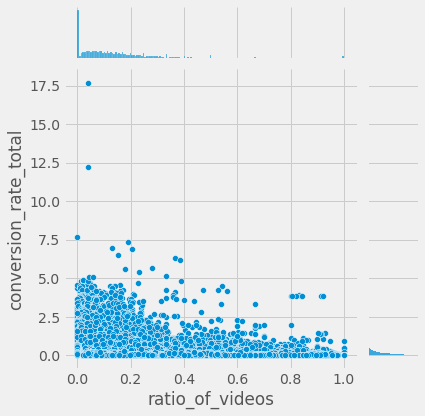

In [37]:
import seaborn as sns
sns.jointplot(data=df, x='ratio_of_videos', y='conversion_rate_total')
plt.show()

# Data Enhancement

To enhance our model, we have decided to scrape the following important featrues:

1. Information about the domicile of the missing companies
2. Some macroeconomic indicators for different countries on the annual basis
3. Information about the date and location of the event, that the clients of the luxury brands are likely to attend

## Macroeconomic indicators

We have added the data on the GDP and GINI index from the World bank. As a lot of companies in our dataset are in the luxury market, **Gini index** might be very informative as it reflects the wealth distribution in the country


<div class="alert alert-block alert-success">
<b>IMPROVEMENT</b> Much more relevant macroeconomic indicators could be scraped from the internet if we had more time :)
</div>